In [1]:
import h5py, os, pickle
from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from ecog.utils import bands
from cv_paper_plots.style import (subject_colors, letter_fontstyle,
                                  ticklabel_fontstyle, subject_labels)
from cv_paper_plots import xfreq_analysis, xfreq_classification

import scipy as sp
from cv_paper_plots.xfreq_analysis import good_examples_and_channels
from cv_paper_plots.broadband import (forward_bl, invert_bl, new_ch_idx, get_pcs, flip,
                                      baseline_mean_std)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/home/jesse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data

In [2]:
folder = os.path.join(os.environ['HOME'],'Development/data/ecog/AA_ff/')
subjects = ['ec2', 'ec9', 'gp31', 'gp33']
files = ['EC2_blocks_1_8_9_15_76_89_105_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'EC9_blocks_15_39_46_49_53_60_63_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP31_blocks_1_2_4_6_9_21_63_65_67_69_71_78_82_83_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP33_blocks_1_5_30_CV_AA_ff_align_window_-0.5_to_0.79_none.h5']
freqs = bands.chang_lab['cfs']

In [54]:
subject_idx = 3
subject = subjects[subject_idx]

In [55]:
baselines = dict()
with h5py.File(os.path.join(folder, files[subject_idx])) as f:
    block_labels = f['block'].value
    for key, value in f.items():
        if ('block' in key) and ('band' in key):
            items = key.split('_')
            block, band = int(items[2]), int(items[4])
            baselines[(block, band)] = np.squeeze(value.value).astype('float32')
    good_examples, good_channels = good_examples_and_channels(f['X0'].value)
    vsmc = np.concatenate([f['anatomy']['preCG'].value, f['anatomy']['postCG'].value])
    vsmc_electrodes = np.zeros(256)
    vsmc_electrodes[vsmc] = 1
    tokens = f['tokens'].value.astype('str').tolist()

    good_examples = sorted(np.nonzero(good_examples)[0].tolist())

    good_channels = sorted(np.nonzero(vsmc_electrodes * good_channels)[0].tolist())
    n_trials, n_channels, n_time = f['X0'].shape
    print(len(good_examples), len(good_channels))
    X = np.zeros((40, len(good_examples), len(good_channels), n_time), dtype='float32')
    block_labels = block_labels[good_examples]
    for ii in range(40):
        X[ii] = f['X{}'.format(ii)][good_examples][:, good_channels]
    labels = f['y'][good_examples]

1422 96


In [56]:
bl_mean, bl_std = baseline_mean_std(block_labels, good_channels, baselines)

In [105]:
print(subject)
X.min(), X.max()

ec2


(0.00029531535, 191.10962)

In [8]:
n0 = np.concatenate((np.arange(0, 29), np.arange(37, 40)))
n1 = np.arange(29, 37)
for b in set(block_labels):
    print(b, X[n0][:, block_labels == b].min(axis=(1, 2, 3)))
    print(b, X[n1][:, block_labels == b].min(axis=(1, 2, 3)))

39 [0.05019796 0.03176962 0.07814107 0.03617371 0.06910831 0.06695546
 0.04110387 0.02977706 0.03721533 0.01593843 0.03651252 0.03974373
 0.03085542 0.04057136 0.03385308 0.01893223 0.02053863 0.02599519
 0.0169923  0.01503886 0.01220735 0.01303586 0.00938158 0.01179164
 0.01051741 0.00551377 0.00922294 0.00627837 0.00697091 0.00324057
 0.00174096 0.00136667]
39 [0.00696741 0.00868858 0.00169716 0.00147085 0.00391736 0.0041791
 0.004372   0.00412208]
46 [0.04290765 0.05102665 0.08350355 0.07614122 0.08034985 0.06845839
 0.08500399 0.05139906 0.06485165 0.05181818 0.05377547 0.03112235
 0.0146659  0.02218149 0.03788565 0.03828774 0.0143523  0.02653148
 0.02474379 0.01366149 0.01747918 0.01776709 0.00687524 0.01256878
 0.01362976 0.00854904 0.01031645 0.00579931 0.0068795  0.00241369
 0.00244195 0.00139049]
46 [0.00629855 0.0073303  0.0076668  0.00362409 0.00374153 0.00304032
 0.00233444 0.00378507]
15 [ 0.5302526   0.3895175   0.52505475  0.5200376   0.6851808   0.97034925
  0.62793326 

In [6]:
X[X <= 0] = X[X > 0].min()

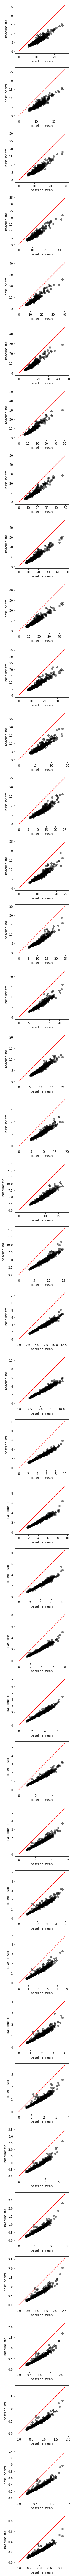

In [106]:
f, axes = plt.subplots(40, figsize=(3.5, 120))
for ii, ax in enumerate(axes):
    x = bl_mean[:, ii].ravel()
    y = bl_std[:, ii].ravel()
    ax.scatter(x, y, c='k', alpha=.5)
    size = 1.05 * max(x.max(), y.max())
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xlabel('baseline mean')
    ax.set_ylabel('baseline std')
    ax.axis('equal')
    ax.plot([0, size], [0, size], c='r')
f.tight_layout()

# Power spectra

IndexError: index 3 is out of bounds for axis 0 with size 3

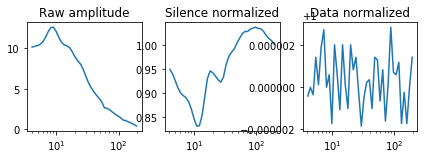

In [114]:
f, axes = plt.subplots(1, 3, figsize=(7, 2), sharex=True)
titles = ['Raw amplitude', 'Silence normalized', 'Data normalized', 'Silence zscore']
for ii, bl_type in enumerate([None, 'bl_mean', 'data_mean', 'bl_zscore']):
    axes[ii].set_title(titles[ii])
    if bl_type is not None:
        X, bl_type_mean = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)
    axes[ii].plot(bands.chang_lab['cfs'], X.mean(axis=(1, 2, 3)))
    if bl_type is not None:
        X = invert_bl(X, bl_type, bl_type_mean, bl_mean, bl_std, block_labels)
    axes[ii].set_xscale('log')
axes[0].set_ylabel('Amplitude')
for ax in axes:
    ax.set_xlabel('Center frequency (Hz)')
    
for ax in axes:
    ax.set_ylim(0, None)
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'],
                         'Downloads/{}_power_spectra.pdf'.format(subject)))

In [18]:
for b in blocks:
    print('block', b)
    idxs = block_labels == b
    print(idxs, idxs.sum())
    Xp = X[:, idxs]
    for ii in range(40):
        print(ii, Xp[ii].mean())
    print()

block 15
[ True  True  True ... False False False] 55
0 197.56625
1 201.01434
2 203.73839
3 205.76628
4 207.15427
5 207.97218
6 208.29214
7 208.1819
8 207.7047
9 206.91896
10 205.87978
11 204.63911
12 203.24675
13 201.74869
14 200.18692
15 198.59845
16 197.01503
17 195.46207
18 193.95955
19 192.5218
20 191.15851
21 189.87567
22 188.6759
23 187.5597
24 186.52544
25 185.5703
26 184.69084
27 183.88277
28 183.14166
29 2.2637317
30 2.0058672
31 1.800924
32 1.5926346
33 1.3957487
34 1.1108218
35 1.0309793
36 0.88786674
37 178.7798
38 178.48538
39 178.21814

block 39
[False False False ... False False False] 272
0 35.004017
1 40.25613
2 44.555866
3 46.434402
4 45.3967
5 41.821964
6 36.627953
7 31.180681
8 26.82695
9 23.892874
10 21.793415
11 19.969862
12 18.284828
13 16.736706
14 15.174413
15 13.395225
16 11.4993305
17 9.789039
18 8.322729
19 7.0755725
20 6.0305405
21 5.2123046
22 4.599848
23 4.165283
24 3.838344
25 3.5310733
26 3.1657033
27 2.4644778
28 2.3788261
29 2.1891296
30 1.9467313
31

# PCA

In [ ]:
rng = np.random.RandomState(20180917)

pcs = np.full((2, 2, 2, len(good_channels), 3, 40), np.nan)
evs = np.full((2, 2, 2, len(good_channels), 3), np.nan)

means = np.full((2, 2, 2, len(good_channels), 40), np.nan)

pcs_s = np.full((2, 2, 2, len(good_channels), 3, 40), np.nan)
evs_s = np.full((2, 2, 2, len(good_channels), 3), np.nan)

for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
    X, bl_type_means = forward_bl(X, bl_type, block_labels)
    for ch in range(len(good_channels)):
        d = X[:, :, ch].reshape(40, -1).T
        for jj, center_pca in enumerate([True, False]):
            for kk, log in enumerate([True, False]):
                if log:
                    dp = np.log(d)
                else:
                    dp = d
                dp_s = np.zeros_like(dp)
                for nn in range(dp.shape[1]):
                    dp_s[:, nn] = rng.permutation(dp[:, nn])
                (w, v), m = get_pcs(dp, center_pca)
                pcs[ii, jj, kk, ch] = v[:, ::-1].T
                evs[ii, jj, kk, ch] = w[::-1]
                means[ii, jj, kk, ch] = m
                (w_s, v_s), _ = get_pcs(dp_s, center_pca)
                pcs_s[ii, jj, kk, ch] = v_s[:, ::-1].T
                evs_s[ii, jj, kk, ch] = w_s[::-1]
    X = invert_bl(X, bl_type, bl_type_means, block_labels)

pcs = flip(pcs)
pcs_s = flip(pcs_s)

In [86]:
np.savez('{}_pca_analysis'.format(subject), pcs=pcs, evs=evs, means=means,
         axes=['bl_type', 'center_pca', 'log'])

In [6]:
def plot_PC0s(pcs, evs, mean, faxes=None, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(1, 2, figsize=(2.5, 12))
    f, (ax0, ax1) = faxes
    ratios = evs[:, 1:]/evs[:, [0]]
    ax0.plot(np.tile(freqs[np.newaxis], (pcs.shape[0], 1)).T, pcs[:, 0].T,
             c='k', alpha=.1)
    ax0.plot(freqs, np.median(pcs[:, 0], axis=0), c='r')
    ax1.errorbar([0, 1], ratios.mean(axis=0), yerr=ratios.std(axis=0),
                 c='k', ls='none', marker='.')
    mean = mean / np.linalg.norm(mean, axis=1, keepdims=True)
    pc0s = pcs[:, 0] / np.linalg.norm(pcs[:, 0], axis=1, keepdims=True)
    ips = abs(np.sum(pc0s * mean, axis=1))
    ax1.errorbar(2, ips.mean(), yerr=ips.std(), c='k', marker='.')
    #ax0.set_xscale('log')
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels([r'$\frac{e_2}{e_1}$', r'$\frac{e_3}{e_1}$', r'$\mu\cdot V_1$'])
    ax1.set_xlim(-1, 3)
    ax1.set_ylim(0, 1.1)
    ax1.set_yticks([0, 1])
    if ylabel is not None:
        ax0.set_ylabel(ylabel)
    return

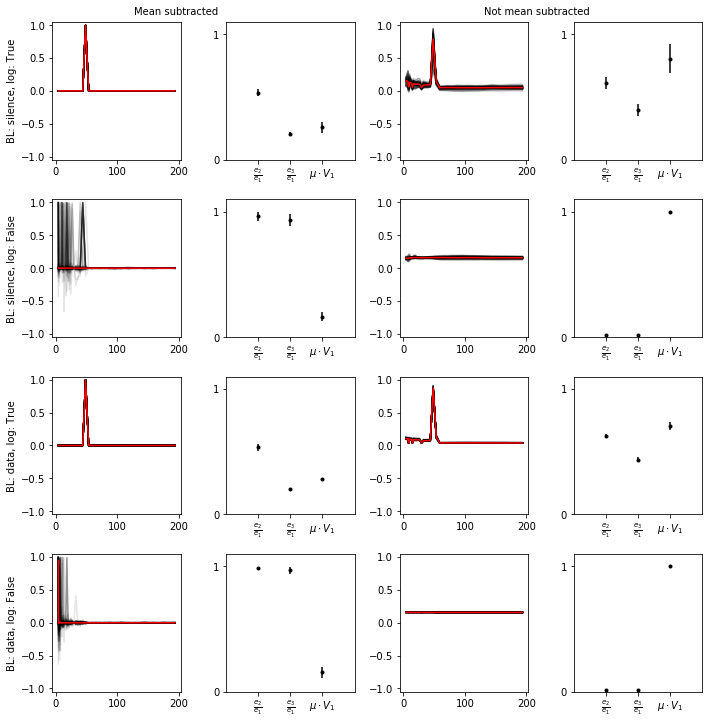

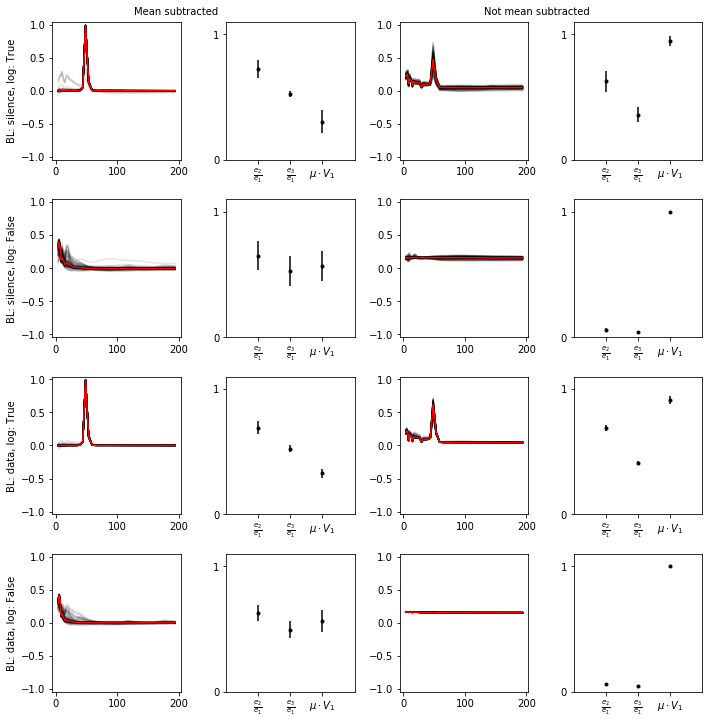

In [89]:
bl_names = ['BL: silence', 'BL: data']
for sampled in [True, False]:
    f, axes = plt.subplots(4, 4, figsize=(10, 10))
    row = 0
    for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
        for kk, log in enumerate([True, False]):
            row_ax = axes[row]
            for jj, center_pca in enumerate([True, False]):
                if row == 0:
                    title=True
                else:
                    title=False
                if jj == 0:
                    ylabel = '{}, log: {}'.format(bl_names[ii], log)
                else:
                    ylabel = None
                if sampled:
                    these_pcs = pcs_s[ii, jj, kk]
                    these_evs = evs_s[ii, jj, kk]
                else:
                    these_pcs = pcs[ii, jj, kk]
                    these_evs = evs[ii, jj, kk]
                these_mean = means[ii, jj, kk]
                axs = row_ax[jj * 2:jj * 2 +2]
                plot_PC0s(these_pcs, these_evs, these_mean,
                          (f, (axs)), title=title, ylabel=ylabel)
            row += 1
    f.text(.25, .99, 'Mean subtracted', ha='center')
    f.text(.75, .99, 'Not mean subtracted', ha='center')
    if sampled:
        max_val = 1.05 * abs(pcs_s).max()
    else:
        max_val = 1.05 * abs(pcs).max()
    for ii, ax in enumerate(axes.ravel()):
        if (ii % 2) == 0:
            ax.set_ylim(-max_val, max_val)
    f.tight_layout()
    if sampled:
        plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_PC1s_sampled.pdf'.format(subject)))
    else:
        plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_PC1s.pdf'.format(subject)))

In [10]:
def plot_103_106(pcs, faxes=None, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(1, 2, figsize=(10, 3))
    f, axes = faxes
    for ax, ch in zip(axes, [103, 106]):
        if title:
            ax.set_title('Electrode: {}'.format(ch))
        for ii in range(3):
            ax.plot(freqs, pcs[new_ch_idx(ch, good_channels), ii], label=ii)
        ax.legend()
        ax.set_xscale('log')
    if ylabel is not None:
        axes[0].set_ylabel(ylabel)
    return

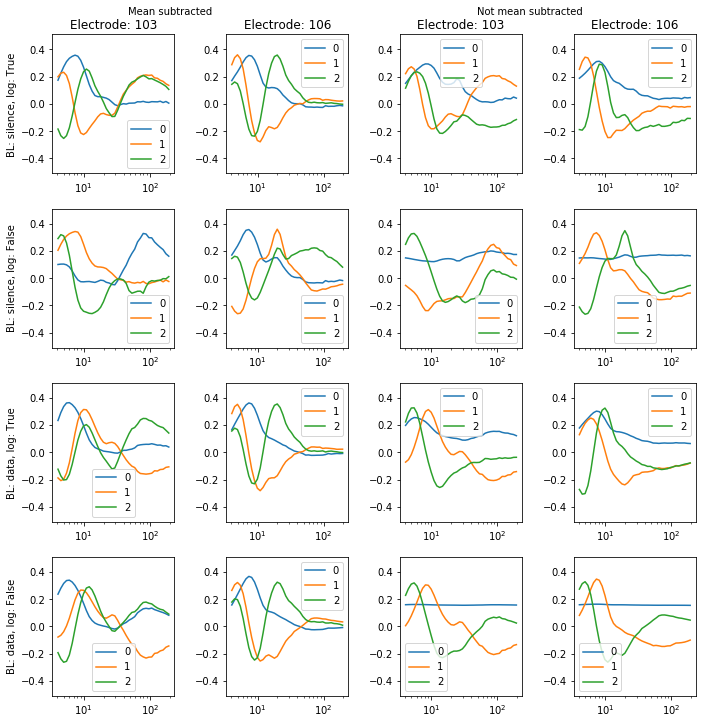

In [60]:
f, axes = plt.subplots(4, 4, figsize=(10, 10))
row = 0
for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
    for kk, log in enumerate([True, False]):
        row_ax = axes[row]
        for jj, center_pca in enumerate([True, False]):
            if row == 0:
                title=True
            else:
                title=False
            if jj == 0:
                ylabel = '{}, log: {}'.format(bl_names[ii], log)
            else:
                ylabel = None
            these_pcs = pcs[ii, jj, kk]
            axs = row_ax[jj * 2:jj * 2 +2]
            plot_103_106(these_pcs, (f, (axs)), title=title, ylabel=ylabel)
        row += 1
f.text(.25, .99, 'Mean subtracted', ha='center')
f.text(.75, .99, 'Not mean subtracted', ha='center')
max_val = 1.05 * abs(pcs).max()
for ax in axes.ravel():
    ax.set_ylim(-max_val, max_val)
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_103_106.pdf'.format(subject)))

In [14]:
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor

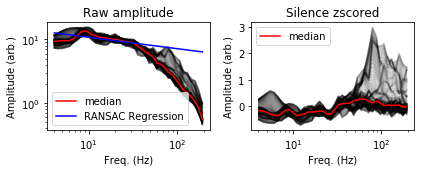

In [31]:
f, axes = plt.subplots(1, 2, figsize=(6, 2.5))
ax = axes.ravel()[0]
cv = np.where(np.array(tokens) == 'gaa')[0]
ch = 103
x = np.tile(bands.chang_lab['cfs'][:, np.newaxis], (1, 258))
y = X[:, labels==cv, new_ch_idx(ch, good_channels)].mean(axis=1)
ax.plot(x, y, c='k', alpha=.1)
ax.plot(x[:, 0], np.median(y, axis=1), c='red', label='median')
model = RANSACRegressor().fit(np.log(x.T).ravel()[:, np.newaxis], np.log(y.T).ravel())
yp = np.exp(model.estimator_.coef_ * np.log(x[:, 0]) + model.estimator_.intercept_)
ax.plot(x[:, 0], yp, c='blue', label='RANSAC Regression')
ax.set_title('Raw amplitude')
ax.set_yscale('log')

ax = axes.ravel()[1]
bl_type = 'bl_zscore'
X, bl_type_mean = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)
x = np.tile(bands.chang_lab['cfs'][:, np.newaxis], (1, 258))
y = X[:, labels==cv, new_ch_idx(ch, good_channels)].mean(axis=1)
ax.plot(x, y, c='k', alpha=.1)
ax.plot(x[:, 0], np.median(y, axis=1), c='red', label='median')
X = invert_bl(X, bl_type, bl_type_mean, bl_mean, bl_std, block_labels)
ax.set_title('Silence zscored')
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_ylabel('Amplitude (arb.)')
    ax.set_xlabel('Freq. (Hz)')
    ax.legend(loc='best')
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/spects.pdf'))

# Remove P1

In [50]:
from cv_paper_plots import xfreq_analysis as xfa

In [8]:
rng = np.random.RandomState(20180917)

pcs = np.full((2, len(good_channels), 3, 40), np.nan)
evs = np.full((2, len(good_channels), 3), np.nan)

means = np.full((2, len(good_channels), 40), np.nan)

pcs_s = np.full((2, len(good_channels), 3, 40), np.nan)
evs_s = np.full((2, len(good_channels), 3), np.nan)

bl_type = 'bl_zscore'
X, bl_type_means = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)
for ch in range(len(good_channels)):
    d = X[:, :, ch].reshape(40, -1).T
    for jj, center_pca in enumerate([True, False]):
        dp = d
        dp_s = np.zeros_like(dp)
        for nn in range(dp.shape[1]):
            dp_s[:, nn] = rng.permutation(dp[:, nn])
        (w, v), m = get_pcs(dp, center_pca)
        pcs[jj, ch] = v[:, ::-1].T
        evs[jj, ch] = w[::-1]
        means[jj, ch] = m
        (w_s, v_s), _ = get_pcs(dp_s, center_pca)
        pcs_s[jj, ch] = v_s[:, ::-1].T
        evs_s[jj, ch] = w_s[::-1]
X = invert_bl(X, bl_type, bl_type_means, bl_mean, bl_std, block_labels)

pcs = flip(pcs)
pcs_s = flip(pcs_s)

In [9]:
np.savez('{}_pca_analysis_zscore'.format(subject), pcs=pcs, evs=evs,
         means=means, axes=['center_pca'])

In [ ]:
d = np.load('{}_pca_analysis_zscore.npz'.format(subject))
pcs = d['pcs']
evs = d['evs']
means = d['means']

In [98]:
def plot_PC0s(pcs, evs, mean, faxes=None, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(1, 2, figsize=(2.5, 12))
    f, (ax0, ax1) = faxes
    ratios = evs[:, 1:]/evs[:, [0]]
    beta_weights = np.zeros(pcs.shape[0])
    beta_weights = (pcs[:, 0, 14:20]).sum(axis=-1)
    beta_weights -= beta_weights.min()
    beta_weights /= beta_weights.max()
    for ii, pc in enumerate(pcs):
        ax0.plot(freqs, pcs[ii, 0],c=cm.Greys(beta_weights[ii]), alpha=1.)
    ax0.plot(freqs, np.median(pcs[:, 0], axis=0), c='r')
    ax0.axhline(0, 0, 1, c='blue', ls='--')
    ax1.errorbar([0, 1], ratios.mean(axis=0), yerr=ratios.std(axis=0),
                 c='k', ls='none', marker='.')
    pc0s = pcs[:, 0] / np.linalg.norm(pcs[:, 0], axis=1, keepdims=True)
    if mean is not None:
        mean = mean / np.linalg.norm(mean, axis=1, keepdims=True)
        ips = abs(np.sum(pc0s * mean, axis=1))
        ax1.errorbar(2, ips.mean(), yerr=ips.std(), c='k', marker='.')
    #ax0.set_xscale('log')
    if mean is None:
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels([r'$\frac{e_2}{e_1}$', r'$\frac{e_3}{e_1}$'])
        ax1.set_xlim(-1, 2)
    else:
        ax1.set_xticks([0, 1, 2])
        ax1.set_xticklabels([r'$\frac{e_2}{e_1}$', r'$\frac{e_3}{e_1}$', r'$\mu\cdot V_1$'])
        ax1.set_xlim(-1, 3)
    ax1.set_ylim(0, 1.1)
    ax1.set_yticks([0, 1])
    if ylabel is not None:
        ax0.set_ylabel(ylabel)
    return

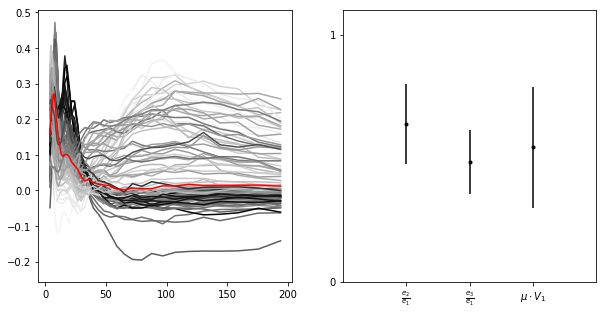

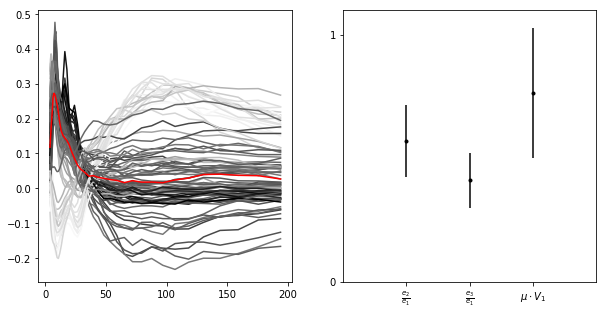

In [26]:
faxes = plt.subplots(1, 2, figsize=(10, 5))
plot_PC0s(pcs[0], evs[0], means[0], faxes=faxes)
faxes = plt.subplots(1, 2, figsize=(10, 5))
plot_PC0s(pcs[1], evs[1], means[1], faxes=faxes)

In [57]:
bl_type = 'bl_zscore'
X, bl_type_means = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)

In [60]:
f = {'y': labels,
     'tokens': tokens,
     'X': X,
     'pcs': pcs[0]}

(40, 2572, 85, 258) (85, 40) (40, 258)
(258,)
-0.6861076 2.9883523
(40, 2572, 85, 258) (85, 40) (40, 258)
(258,)
-0.5671391 0.5573406


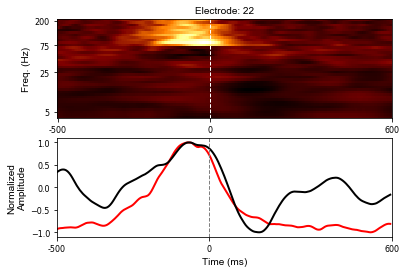

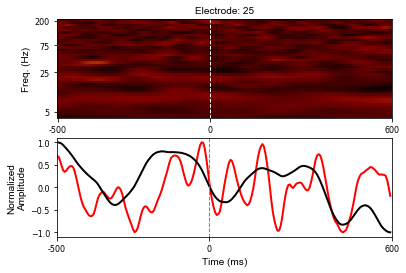

In [47]:
reload(xfa)
for ch in [103, 106]:
    new_ch = new_ch_idx(ch, good_channels)
    xfa.save_power(f, new_ch, 'gaa', subject, bb=True)
    _, axes = plt.subplots(2)
    xfa.plot_power(subject, new_ch, 'gaa', axes, vmin=-0.6861076, vmax=2.9883523, bb=True)

In [44]:
reload(xfa)
xfa.save_correlations(f, subject, bb=True)

In [61]:
reload(xfa)
xfa.save_hg_power(f, subject, bb=True)

-0.6861076 2.9883523
-0.5671391 0.5573406


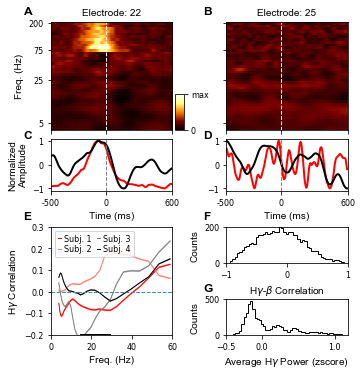

In [70]:
reload(xfreq_analysis)

plt.close()
f = plt.figure(figsize=(5, 5))

l_edge = .125
t_edge = .05
r_edge = .05
b_edge = .08

h_gap = .15

v1_gap = .025
v2_gap = .1

r1_height = .3
r3_height = .3
r2_height = 1. - t_edge - r1_height - v1_gap - v2_gap - r3_height - b_edge

width = (1. - l_edge - r_edge - h_gap) / 2.

c1_x = l_edge + width + h_gap

r1_y = v1_gap + r2_height + v2_gap + r3_height + b_edge
ax0 = f.add_axes([l_edge, r1_y, width, r1_height])
ax1 = f.add_axes([c1_x, r1_y, width, r1_height])
cax = f.add_axes([c1_x - .95 * h_gap, 1. * r1_y, .025, .1])

r2_y =v2_gap + r3_height + b_edge
ax2 = f.add_axes([l_edge, r2_y, width, r2_height])
ax3 = f.add_axes([c1_x, r2_y, width, r2_height])

r3_y = b_edge
ax4 = f.add_axes([l_edge, r3_y, width, r3_height])
r3_half_height = (r3_height - v2_gap) / 2
ax5 = f.add_axes([c1_x, r3_y + r3_half_height + v2_gap, width, r3_half_height])
ax6 = f.add_axes([c1_x, r3_y, width, r3_half_height])

subject = 'ec2'
cv = 'gaa'
ch = 22
vmin = -0.6861076
vmax = 2.9883523
im = xfreq_analysis.plot_power(subject, ch, cv, [ax0, ax2], vmin=vmin, vmax=vmax, bb=True)

c = f.colorbar(im, cax=cax)
c.set_ticks([vmin, vmax])
c.set_ticklabels([0, 'max'])
c.ax.tick_params(labelsize=ticklabel_fontstyle['fontsize'])

ch = 25
xfreq_analysis.plot_power(subject, ch, cv, [ax1, ax3], vmin=vmin, vmax=vmax, bb=True)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_ylabel('')
ax3.set_ylabel('')

xfreq_analysis.plot_correlations(subjects, ax4, kind='freq', bb=True)

xfreq_analysis.plot_correlation_histogram(subject, ax5, bb=True)

xfreq_analysis.plot_power_histogram(subject, ax6, bb=True)


x0 = .05
y0 = .97
x1 = .55
y1 = .625
y2 = .4
y3 = .2

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)
f.text(x0, y1, 'C', **letter_fontstyle)
f.text(x1, y1, 'D', **letter_fontstyle)
f.text(x0, y2, 'E', **letter_fontstyle)
f.text(x1, y2, 'F', **letter_fontstyle)
f.text(x1, y3, 'G', **letter_fontstyle)

plt.savefig('/home/jesse/Downloads/xfreq1_bb.eps', dpi=300)
plt.savefig('/home/jesse/Downloads/xfreq1_bb.png', dpi=300)

plt.show()

ec2, 	m: -5.77e-03, 	b: -1.59e-01, 	R^2: 1.40e-05, 	p: 8.63e-01, 	stderr: 3.34e-02
gp33, 	m: -3.10e-01, 	b: 1.22e-02, 	R^2: 1.24e-02, 	p: 1.29e-07, 	stderr: 5.85e-02


/home/jesse/Development/cv_paper_plots/cv_paper_plots/xfreq_analysis.py:822: RuntimeWarning: Mean of empty slice.
  mean = xcorr_freq_low.mean(axis=(1))
/home/jesse/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/jesse/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jesse/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jesse/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/jesse/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in

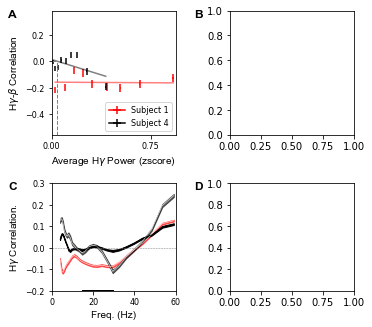

In [71]:
reload(xfa)
plt.close()
figsize=(5, 4.5)
f = plt.figure(figsize=figsize)
x_over_y = figsize[0] / figsize[1]

l_edge = .13
t_edge = .02
r_edge = .03
b_edge = .115

v_gap = .15

h_gap = .15

width = (1. - l_edge - r_edge - h_gap) / 2.

r0_height = width * x_over_y
r1_height = (1. - t_edge - r0_height - v_gap - b_edge)

c1_x = l_edge + width + h_gap

r0_y = r1_height + v_gap + b_edge
ax0 = f.add_axes([l_edge, r0_y, width, r0_height])
ax1 = f.add_axes([c1_x, r0_y, width, r0_height])

r1_y = b_edge
ax2 = f.add_axes([l_edge, r1_y, width, r1_height])
ax3 = f.add_axes([c1_x, r1_y, width, r1_height])

pcts = xfa.plot_power_correlations(['ec2', 'gp33'], ax0, bb=True)

#xfa.plot_power_correlations(['ec9', 'gp31'], ax1, cutoff_pct=np.mean(pcts), bb=True)
                                       
xfa.plot_resolved_power_correlations(['ec2', 'gp33'], ax2, bb=True)
#xfa.plot_resolved_power_correlations(['ec9', 'gp31'], ax3, hline_c='black', bb=True)

x0 = .01
y0 = r0_y + r0_height - .02
x1 = .525
y1 = r1_y + r1_height - .02

f.text(x0, y0, 'A', **letter_fontstyle)
f.text(x1, y0, 'B', **letter_fontstyle)
f.text(x0, y1, 'C', **letter_fontstyle)
f.text(x1, y1, 'D', **letter_fontstyle)

plt.savefig('/home/jesse/Downloads/xfreq2_bb.eps', dpi=300)
plt.savefig('/home/jesse/Downloads/xfreq2_bb.png', dpi=300)

plt.show()

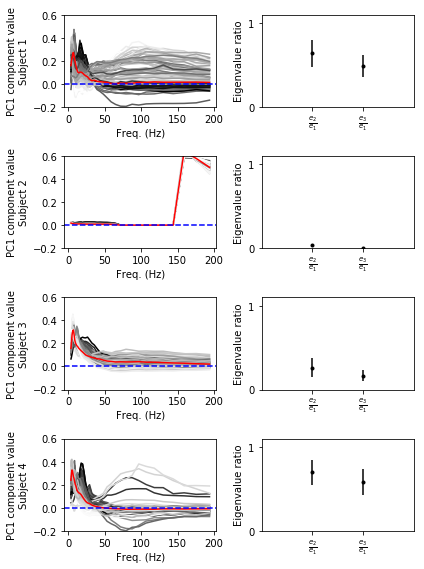

In [99]:
f, axes = plt.subplots(4, 2, figsize=(6, 8))
for ii, subject in enumerate(subjects):
    ax = axes[ii]
    d = np.load('{}_pca_analysis_zscore.npz'.format(subject))
    pcs = d['pcs']
    evs = d['evs']
    #means = d['means']
    plot_PC0s(pcs[0], evs[0], None, faxes=(f, ax))
    ax[0].set_ylabel('PC1 component value\n{}'.format(subject_labels[subject]))
for ax in axes[:, 0]:
    ax.set_xlabel('Freq. (Hz)')
    ax.set_ylim(-.2, .6)
for ax in axes[:, 1]:
    ax.set_ylabel('Eigenvalue ratio')
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/PC1s.pdf'))

In [36]:
from sklearn.cluster import KMeans
from matplotlib import cm

In [34]:
def cluster_PC0s(pcs, n_clusters=3, faxes=None, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(n_clusters)
    f, axes = faxes
    beta_weights = np.zeros(pcs.shape[0])
    beta_weights = (pcs[:, 0, 14:20]).sum(axis=-1)
    print(pcs.shape[0])
    beta_weights -= beta_weights.min()
    beta_weights /= beta_weights.max()
    model = KMeans(n_clusters=n_clusters)
    y = model.fit_predict(pcs[:, 0])
    print(pcs.shape)
    for ii, pc0 in enumerate(pcs[:, 0]):
        yi = y[ii]
        axes[yi].plot(freqs, pc0 ,c=cm.Greys(beta_weights[ii]), alpha=1.)
    for ii, ax in enumerate(axes):
        ax.plot(freqs, np.median(pcs[y == ii, 0], axis=0), c='r')
        ax.axhline(0, 0, 1, c='blue', ls='--')
    return

85
(85, 3, 40)


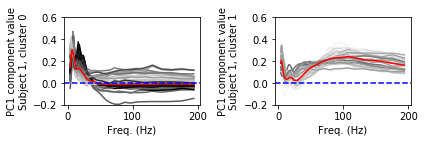

In [47]:
subject = 'ec2'
d = np.load('{}_pca_analysis_zscore.npz'.format(subject))
pcs = d['pcs']
n_clusters = 2
faxes = plt.subplots(1, n_clusters, figsize=(3*n_clusters, 2))
cluster_PC0s(pcs[0], n_clusters=n_clusters, faxes=faxes)
f, axes = faxes
for ii, ax in enumerate(axes.ravel()):
    ax.set_xlabel('Freq. (Hz)')
    ax.set_ylim(-.2, .6)
    ax.set_ylabel('PC1 component value\n{}, cluster {}'.format(subject_labels[subject], ii))
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/Subject1_PC1s.pdf'))

In [42]:
faxes

(<matplotlib.figure.Figure at 0x7f7842cfc208>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7842b34dd8>,
       dtype=object))